In [ ]:
# Based on https://keras.io/examples/vision/image_classification_from_scratch/

In [ ]:
# Importing dataset from Kaggle
!pip install -q kaggle
!wget https://raw.githubusercontent.com/alothomas/ML4HProject1/main/kaggle.json

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-04

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

In [ ]:
print("Number of available GPUs:", len(tf.config.list_physical_devices('GPU')))

Number of available GPUs: 1


In [ ]:
# Import dataset
image_size = (224, 224)
batch_size = 32
train_folder = 'chest_xray/chest_xray/train/'
test_folder = 'chest_xray/chest_xray/test/'

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    train_folder,
    label_mode='categorical',
    class_names=['NORMAL', 'PNEUMONIA'],
    color_mode='grayscale',
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_folder,
    label_mode='categorical',
    class_names=['NORMAL', 'PNEUMONIA'],
    color_mode='grayscale',
    shuffle=False,
    image_size=image_size,
    batch_size=batch_size,
)

# select 5 negative and 5 positive samples from the test set for later
neg_ds = test_ds.unbatch().filter(lambda img, label: label[0] == 1).take(5)
pos_ds = test_ds.unbatch().filter(lambda img, label: label[1] == 1).take(5)

# uncomment following line to shuffle train set labels for Q5
#train_ds = train_ds.map(lambda x, y: (x, tf.random.shuffle(y)))

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.


## Exploration

In [ ]:
y_train = tf.concat([y for _, y in train_ds], axis=0)
neg, pos = np.bincount(y_train[:, 0] == 0)
print('Training dataset contains %i negative and %i positive samples' %(neg, pos))

Training dataset contains 1092 negative and 3081 positive samples


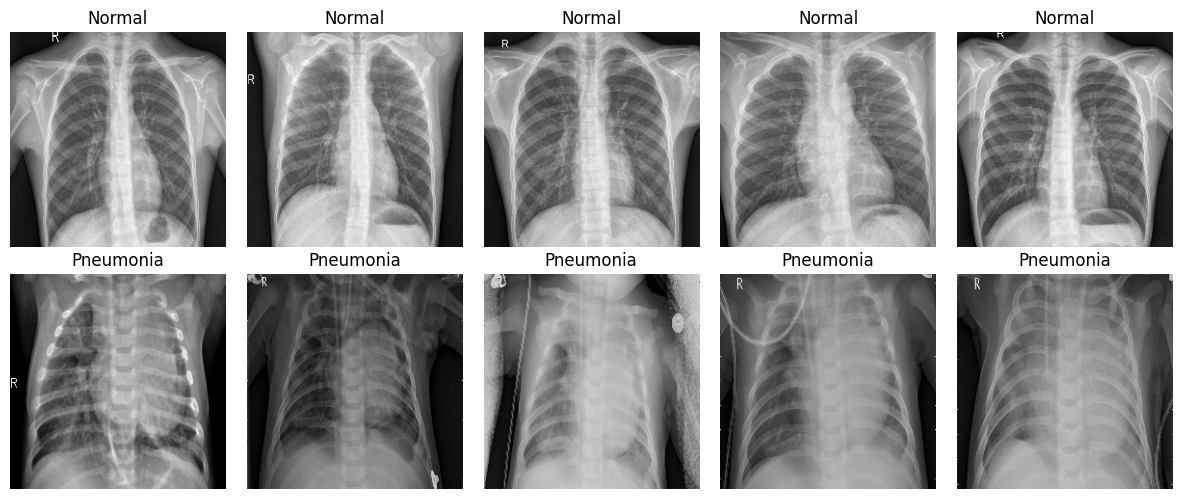

In [ ]:
# create figure and set titles
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
axes[0, 0].set_title("Positive")
axes[1, 0].set_title("Negative")

for i, (image, label) in enumerate(neg_ds):
    axes[0, i].imshow(image, cmap='gray')
    axes[0, i].set_title("Normal")
    axes[0, i].axis("off")
for i, (image, label) in enumerate(pos_ds):
    axes[1, i].imshow(image, cmap='gray')
    axes[1, i].set_title("Pneumonia")
    axes[1, i].axis("off")

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

## CNN

In [ ]:
def make_cnn(input_shape):
    n_hidden = 8
    model = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape),
        layers.Rescaling(1./255),

        # 1 x 224 x 224
        layers.Conv2D(filters=n_hidden, kernel_size=3, padding="same"),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=2),

        # n_hidden x 112 x 112
        layers.Conv2D(filters=2*n_hidden, kernel_size=3, padding="same"),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=2),

        # 2*n_hidden x 56 x 56
        layers.Conv2D(filters=4*n_hidden, kernel_size=3, padding="same"),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=2),

        # 4*n_hidden x 28 x 28
        layers.Conv2D(filters=8*n_hidden, kernel_size=3, padding="same"),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=2),

        # 8*n_hidden x 14 x 14
        layers.Conv2D(filters=16*n_hidden, kernel_size=3, padding="same", name='last_conv'),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=2),

        # 16*n_hidden x 7 x 7
        layers.Flatten(),
        layers.Dense(2, activation='softmax'),
    ])
    return model


model = make_cnn(input_shape=image_size + (1,))
model.summary()

In [ ]:
# Calculate class weights to counter class imbalance
y_train = tf.concat([y for _, y in train_ds], axis=0)
total = y_train.shape[0]
neg, pos = np.bincount(y_train[:, 0] == 0)
w0 = (1 / neg) * (total / 2.0)
w1 = (1 / pos) * (total / 2.0)
class_weight = {0: w0, 1: w1}
print(class_weight)

{0: 1.9107142857142858, 1: 0.6772151898734177}


In [ ]:
# Training the model
epochs = 10
optimizer = keras.optimizers.Adam(1e-5)
metrics = [
    "accuracy",
    keras.metrics.Precision(name='precision', class_id=1),
    keras.metrics.Recall(name='recall', class_id=1),
]
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=metrics,
)
model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    class_weight=class_weight,
)

Epoch 1/10
131/131 [==============================] - 32s 191ms/step - loss: 0.3646 - accuracy: 0.8296 - precision: 0.9428 - recall: 0.8189 - val_loss: 0.4442 - val_accuracy: 0.7824 - val_precision: 0.7804 - val_recall: 0.9937
Epoch 2/10
131/131 [==============================] - 27s 195ms/step - loss: 0.1662 - accuracy: 0.9300 - precision: 0.9827 - recall: 0.9215 - val_loss: 0.2148 - val_accuracy: 0.9166 - val_precision: 0.9087 - val_recall: 0.9899
Epoch 3/10
131/131 [==============================] - 28s 203ms/step - loss: 0.1152 - accuracy: 0.9545 - precision: 0.9875 - recall: 0.9503 - val_loss: 0.1306 - val_accuracy: 0.9530 - val_precision: 0.9662 - val_recall: 0.9723
Epoch 4/10
131/131 [==============================] - 27s 192ms/step - loss: 0.0889 - accuracy: 0.9660 - precision: 0.9933 - recall: 0.9604 - val_loss: 0.1196 - val_accuracy: 0.9521 - val_precision: 0.9806 - val_recall: 0.9559
Epoch 5/10
131/131 [==============================] - 26s 188ms/step - loss: 0.0724 - accura

20/20 [==============================] - 2s 95ms/step
(624,)
Metrics computed on test datatset:
Loss: 0.6556628942489624
Accuracy: 0.7868589758872986
Precision: 0.7504873275756836
Recall: 0.9871794581413269
F1-score: 0.8527131782945737


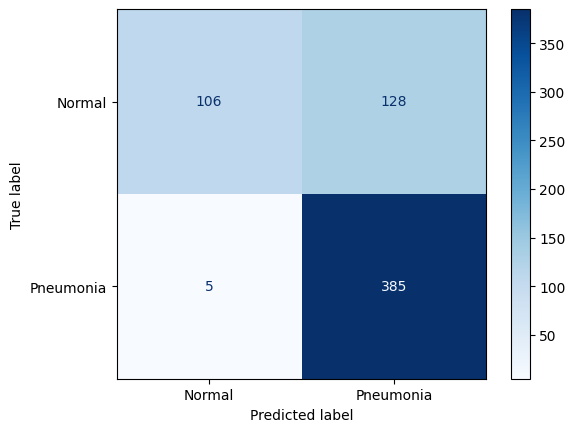

In [ ]:
# Evaluate model on test dataset
loss, acc, precision, recall = model.evaluate(test_ds)
preds = np.argmax(model.predict(test_ds), axis=-1)
y_test = np.argmax(tf.concat([y for _, y in test_ds], axis=0), axis=-1)
print(preds.shape)
print('Metrics computed on test datatset:')
print("Loss:", loss)
print("Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score(y_test, preds))

# Confusion matrix
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Integrated Gradients
source: https://www.tensorflow.org/tutorials/interpretability/integrated_gradients

In [ ]:
def interpolate_images(baseline,
                       image,
                       alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(image, axis=0)
    delta = input_x - baseline_x
    images = baseline_x + alphas_x * delta
    return images


def compute_gradients(images, target_class_idx):
    with tf.GradientTape() as tape:
        tape.watch(images)
        logits = model(images)
        probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
    return tape.gradient(probs, images)


def integral_approximation(gradients):
    # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients


def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
    # Generate alphas.
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

    # Collect gradients.
    gradient_batches = []

    # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
    for alpha in tf.range(0, len(alphas), batch_size):
        from_ = alpha
        to = tf.minimum(from_ + batch_size, len(alphas))
        alpha_batch = alphas[from_:to]

        gradient_batch = one_batch(baseline, image, alpha_batch, target_class_idx)
        gradient_batches.append(gradient_batch)

    # Concatenate path gradients together row-wise into single tensor.
    total_gradients = tf.concat(gradient_batches, axis=0)

    # Integral approximation through averaging gradients.
    avg_gradients = integral_approximation(gradients=total_gradients)

    # Scale integrated gradients with respect to input.
    integrated_gradients = (image - baseline) * avg_gradients

    return integrated_gradients


@tf.function
def one_batch(baseline, image, alpha_batch, target_class_idx):
    # Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    # Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)
    return gradient_batch

In [ ]:
baseline = tf.zeros(shape=(224, 224, 1))
cmap = plt.cm.inferno
alpha = 0.3

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

for i, (image, label) in enumerate(neg_ds):
    attributions = integrated_gradients(baseline=baseline,
                                    image=image,
                                    target_class_idx=np.argmax(label),
                                    m_steps=240)
    attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

    # Show image
    axes[0, i].imshow(attribution_mask, cmap=cmap)
    axes[0, i].imshow(image, cmap='gray', alpha=alpha)
    axes[0, i].set_title("Normal")
    axes[0, i].axis("off")

for i, (image, label) in enumerate(pos_ds):
    attributions = integrated_gradients(baseline=baseline,
                                    image=image,
                                    target_class_idx=np.argmax(label),
                                    m_steps=240)
    attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

    # Show image
    axes[1, i].imshow(attribution_mask, cmap=cmap)
    axes[1, i].imshow(image, cmap='gray', alpha=alpha)
    axes[1, i].set_title("Pneumonia")
    axes[1, i].axis("off")

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

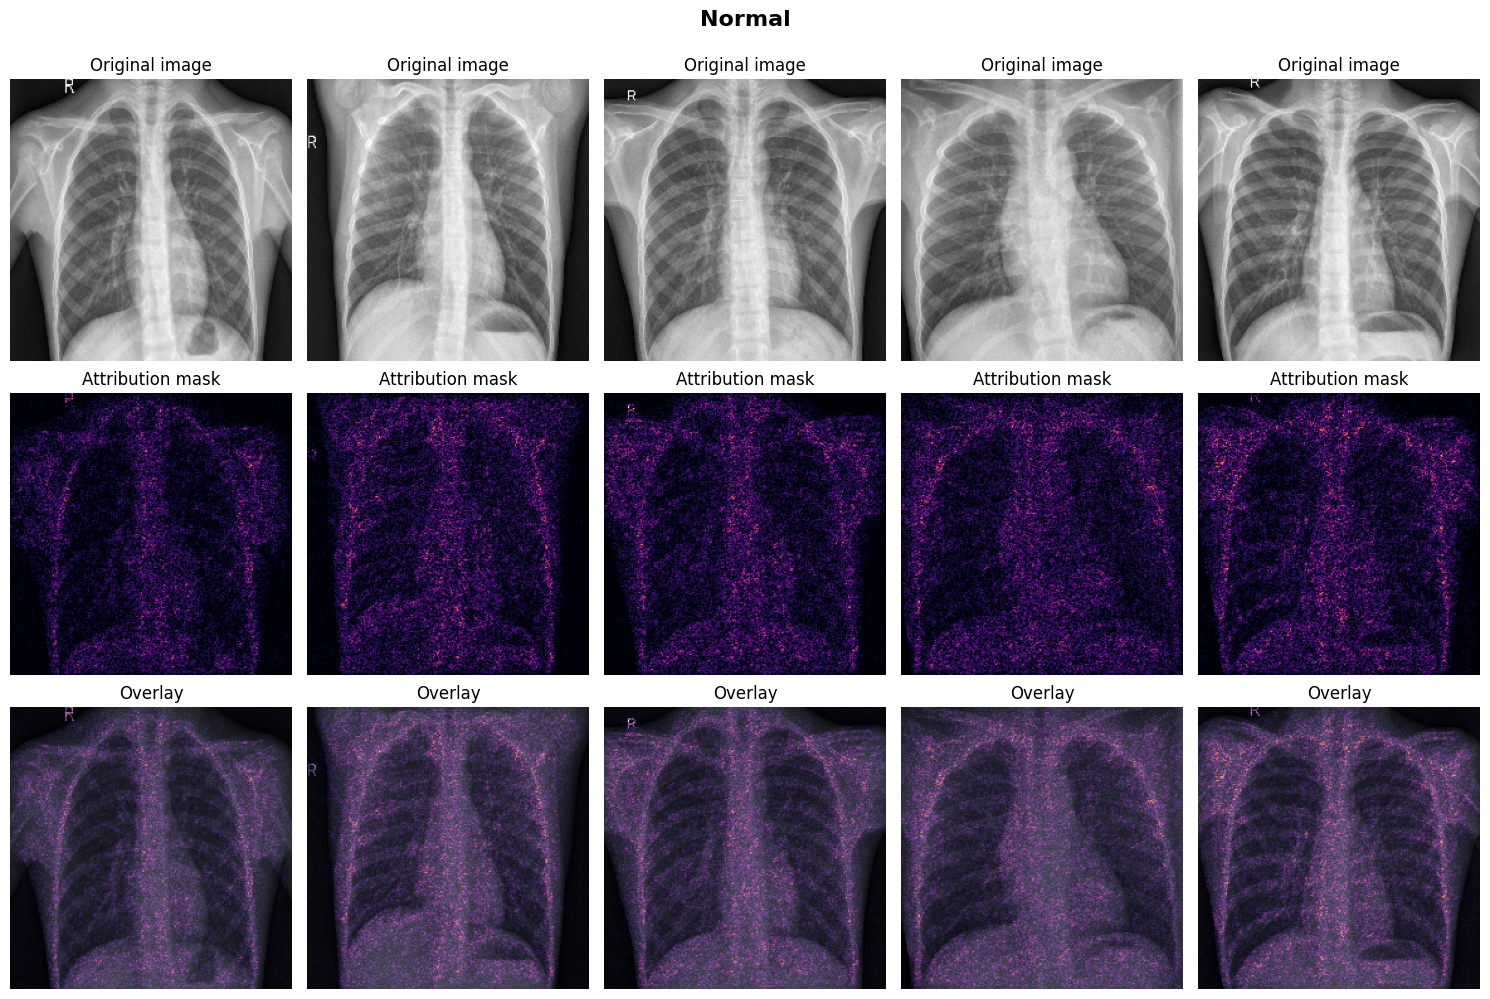

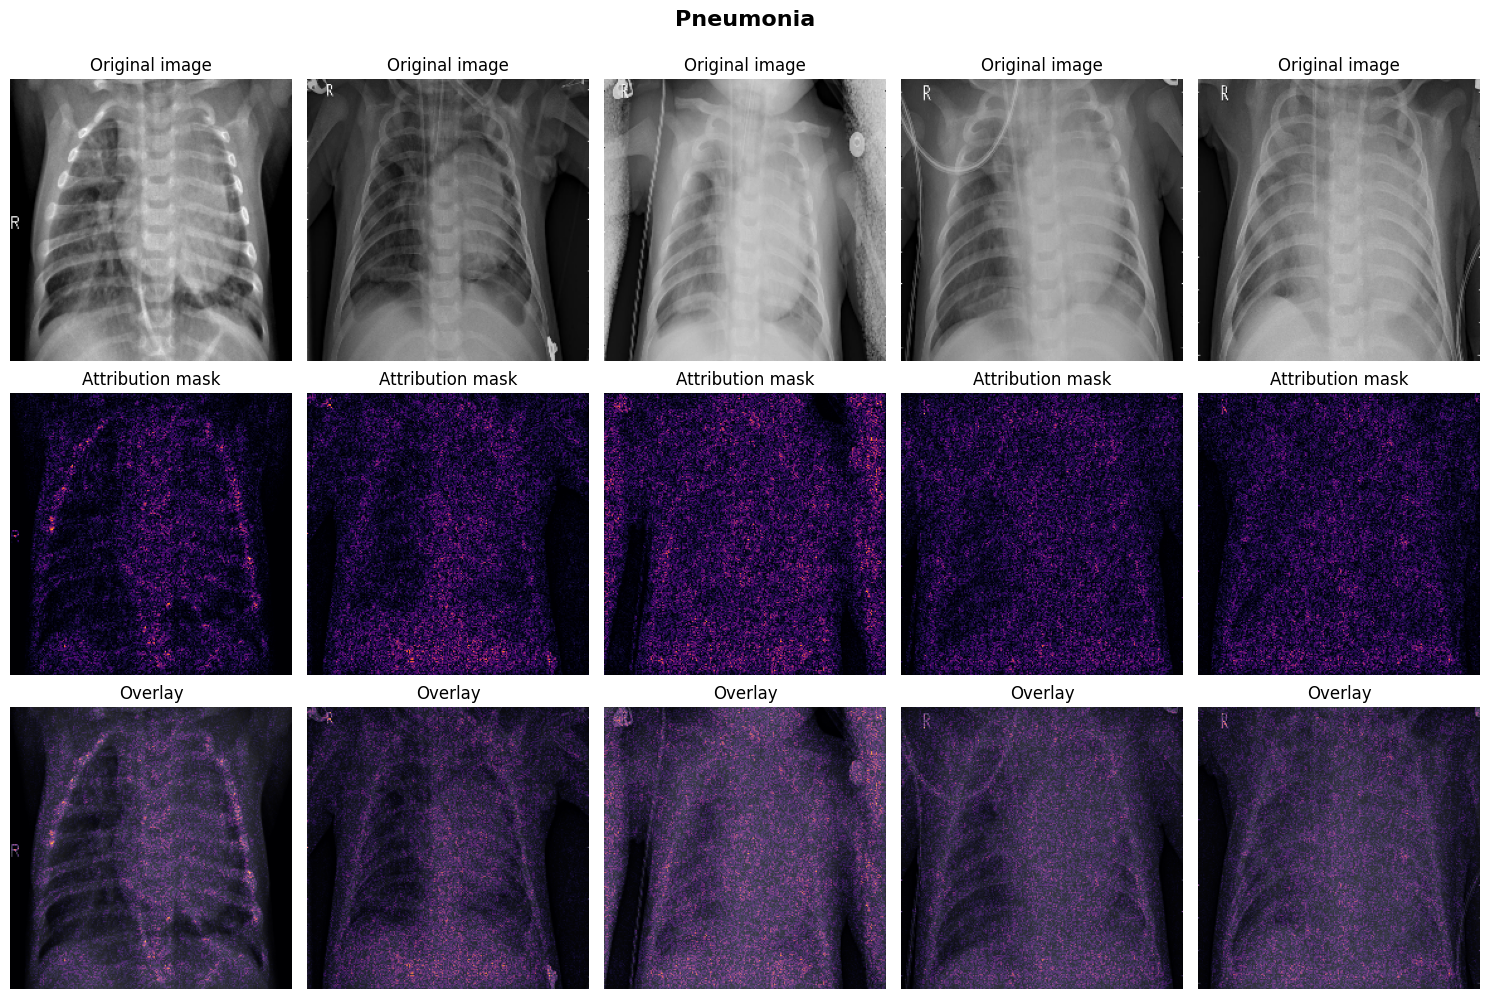

In [ ]:
baseline = tf.zeros(shape=(224, 224, 1))
cmap = plt.cm.inferno
overlay_alpha = 0.3

# show neg samples
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(15, 10))
fig.suptitle("Normal", fontsize=16, fontweight='bold', y=1)
for i, (image, label) in enumerate(neg_ds):
    attributions = integrated_gradients(baseline=baseline,
                                        image=image,
                                        target_class_idx=np.argmax(label),
                                        m_steps=240)

    # Sum of the attributions across color channels for visualization.
    # The attribution mask shape is a grayscale image with height and width
    # equal to the original image.
    attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

    axs[0, i].set_title('Original image')
    axs[0, i].imshow(image, cmap='gray')
    axs[0, i].axis('off')

    axs[1, i].set_title('Attribution mask')
    axs[1, i].imshow(attribution_mask, cmap=cmap)
    axs[1, i].axis('off')

    axs[2, i].set_title('Overlay')
    axs[2, i].imshow(attribution_mask, cmap=cmap)
    axs[2, i].imshow(image, cmap='gray', alpha=overlay_alpha)
    axs[2, i].axis('off')

    plt.tight_layout()

# show pos samples
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(15, 10))
fig.suptitle("Pneumonia", fontsize=16, fontweight='bold', y=1)
for i, (image, label) in enumerate(pos_ds):
    attributions = integrated_gradients(baseline=baseline,
                                        image=image,
                                        target_class_idx=np.argmax(label),
                                        m_steps=240)

    # Sum of the attributions across color channels for visualization.
    # The attribution mask shape is a grayscale image with height and width
    # equal to the original image.
    attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

    axs[0, i].set_title('Original image')
    axs[0, i].imshow(image, cmap='gray')
    axs[0, i].axis('off')

    axs[1, i].set_title('Attribution mask')
    axs[1, i].imshow(attribution_mask, cmap=cmap)
    axs[1, i].axis('off')

    axs[2, i].set_title('Overlay')
    axs[2, i].imshow(attribution_mask, cmap=cmap)
    axs[2, i].imshow(image, cmap='gray', alpha=overlay_alpha)
    axs[2, i].axis('off')

    plt.tight_layout()

## Grad-CAM
source: https://keras.io/examples/vision/grad_cam/

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

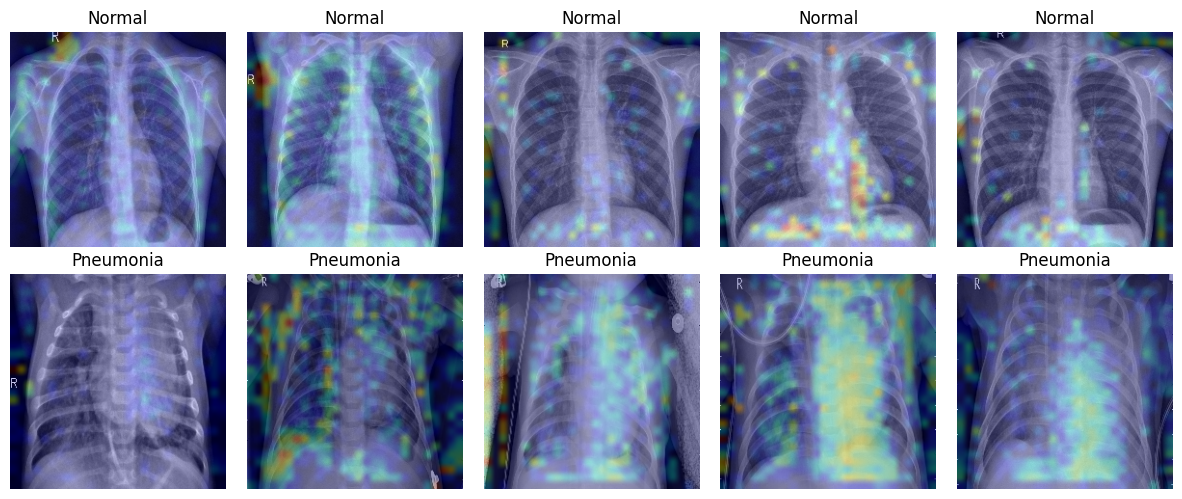

In [ ]:
# Remove last layer's softmax
model.layers[-1].activation = None

alpha = 0.4

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

for i, (image, label) in enumerate(neg_ds):
    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(np.expand_dims(image, axis=0), model, 'last_conv')
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize(image_size)
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + image
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Show image
    axes[0, i].imshow(superimposed_img)
    axes[0, i].set_title("Normal")
    axes[0, i].axis("off")

for i, (image, label) in enumerate(pos_ds):
    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(np.expand_dims(image, axis=0), model, 'last_conv')
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize(image_size)
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + image
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Show image
    axes[1, i].imshow(superimposed_img)
    axes[1, i].set_title("Pneumonia")
    axes[1, i].axis("off")

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()